In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [160]:
cd /content/drive/MyDrive/iitp/Facial-Expression-Recognition/modeling

/content/drive/MyDrive/iitp/Facial-Expression-Recognition/modeling


In [161]:
from tqdm import tqdm
import re
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import random
import keras
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import IPython.display as display


In [162]:
@tf.function
def landmark_tfrecord_reader(example):
    feature_description = {"image": tf.io.VarLenFeature(dtype=tf.string),
                           "class": tf.io.VarLenFeature(dtype=tf.float32),
                           "landmark_points": tf.io.VarLenFeature(dtype=tf.float32)}

    inputs = {}
    example = tf.io.parse_single_example(example, feature_description)
    image_raw = tf.sparse.to_dense(example["image"])[0]
    inputs['image'] = tf.io.decode_png(image_raw, channels=3)
    image_class = tf.cast(tf.sparse.to_dense(example["class"]), tf.float32)
    inputs['image_landmarks'] = tf.cast(tf.sparse.to_dense(example["landmark_points"]), tf.float32)
    return inputs, image_class

In [187]:
def image_scaling(x, y):
    x['image'] = tf.cast(x['image'], tf.float32) / 255.
    # x 480pixel, y 640pixel
    x['image_landmarks'] = tf.cast(x['image_landmarks'] / 640., tf.float32)
    return x, y

In [188]:
filenames = '../data/face_data_regress.tfrecord'
ds = tf.data.TFRecordDataset(filenames).map(landmark_tfrecord_reader)
ds = ds.map(image_scaling).batch(32)
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# dataset = tf.data.TFRecordDataset(filenames = ['../data/face_data4.tfrecord'])
# raw_example = next(iter(dataset))
# parsed = tf.train.Example.FromString(raw_example.numpy())

# parsed.features.feature['class']

int64_list {
  value: 0
}

In [183]:
ds_size = len(list(ds))
ds_size

35

In [184]:
train_size = int(0.7 * ds_size)
val_size = int(0.15 * ds_size)
test_size = int(0.15 * ds_size)

train_ds = ds.take(train_size)
test_ds = ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [168]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"./Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  # early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  # callbacks = [early_stopping, checkpoint]
  callbacks = [checkpoint]
  return callbacks

In [185]:
lds = list(ds)

In [190]:
lds[0][0]['image_landmarks']

<tf.Tensor: shape=(32, 266), dtype=float32, numpy=
array([[0.325    , 0.2125   , 0.3578125, ..., 0.478125 , 0.4234375,
        0.484375 ],
       [0.465625 , 0.3046875, 0.4875   , ..., 0.509375 , 0.5046875,
        0.5265625],
       [0.290625 , 0.3578125, 0.3125   , ..., 0.51875  , 0.3390625,
        0.534375 ],
       ...,
       [0.3015625, 0.3640625, 0.321875 , ..., 0.5375   , 0.375    ,
        0.540625 ],
       [0.2703125, 0.328125 , 0.2984375, ..., 0.5546875, 0.3859375,
        0.5390625],
       [0.3359375, 0.296875 , 0.3578125, ..., 0.4609375, 0.415625 ,
        0.4546875]], dtype=float32)>

# with mobilenetV2

### 새롭게 모델 다운

In [ ]:
# # sequential 클래스 이용
# model2 = keras.models.Sequential()

# model2.add(keras.layers.Input(shape=(224,224,3)))
# model2.add(tf.keras.applications.mobilenet_v2.MobileNetV2(
#     input_shape=(224,224,3), alpha=1.0, include_top=False, weights='imagenet'
# ))
# model2.add(keras.layers.Flatten())

# model2.add(keras.layers.Dense(128))
# model2.add(keras.layers.BatchNormalization())
# model2.add(keras.layers.Activation('relu'))
# model2.add(keras.layers.Dropout(0.6))

# model2.add(keras.layers.Dense(64))

# # model2.add(keras.layers.Dense(1, activation='softmax'))
# model2.add(keras.layers.Dense(1, activation='sigmoid'))
# model2.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     loss='binary_crossentropy',
#     metrics=['accuracy'])

In [ ]:
moblienet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224,224,3), alpha=1.0, include_top=False, weights='imagenet'
)

9420800/9406464 [==============================] - 0s 0us/step


In [193]:
# 함수형 api
input = keras.layers.Input(shape=(224,224,3), name='image')
x_image = moblienet(input)
x_image = keras.layers.GlobalMaxPooling2D()(x_image)
# x_image = keras.layers.Flatten()(x_image)
x_image = keras.layers.Dense(256)(x_image)
x_image = keras.layers.Dense(128)(x_image)

# input2 = keras.layers.Input(shape=(266,), name='image_landmarks')
# x_landmarks = keras.layers.Flatten()(input2)
# x_landmark = keras.layers.Dense(128, input_dim=266)(x_landmarks)
# x_landmark = keras.layers.BatchNormalization()(x_landmark)
# x_landmark = keras.layers.Activation('relu')(x_landmark)
# x = keras.layers.concatenate([x_image, x_landmark], axis=-1)

x = keras.layers.Dense(256)(x_image)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Dense(128)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(64)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)

model2 = keras.models.Model([input, input2], output)
model2.compile(
    optimizer=tf.keras.optimizers.Adamax(0.0001),
    loss='mse',
    metrics=['accuracy'])

### 기존 모델로 계속 학습

In [ ]:
model2 = tf.keras.models.load_model('Checkpoints/moblienetV2_4.h5')

### 모델 학습

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model2)
# plot_model(model2, to_file='model.png')

In [ ]:
model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_landmarks (InputLayer)   [(None, 266)]        0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['image[0][0]']                  
 al)                                                                                              
                                                                                            

In [194]:
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbackFunction('moblienetV2_landmark_regress_1'), batch_size=32)

Epoch 1/30
     15/Unknown - 12s 200ms/step - loss: nan - accuracy: 0.4729

KeyboardInterrupt: ignored

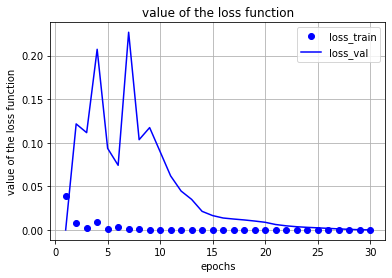

In [ ]:
loss = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

In [ ]:
train_loss, train_acc = model2.evaluate(train_ds)
print('Train Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model2.evaluate(test_ds)
print('Test Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model2.evaluate(val_ds)
print('Validation Accuracy:', val_acc*100)

24/24 [==============================] - 1s 42ms/step - loss: 0.0014 - accuracy: 0.9987
Train Accuracy: 99.86979365348816


5/5 [==============================] - 1s 49ms/step - loss: nan - accuracy: 1.0000
Test Accuracy: 100.0


6/6 [==============================] - 2s 55ms/step - loss: 4.9949e-05 - accuracy: 1.0000
Validation Accuracy: 100.0


### 결과 확인하기

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


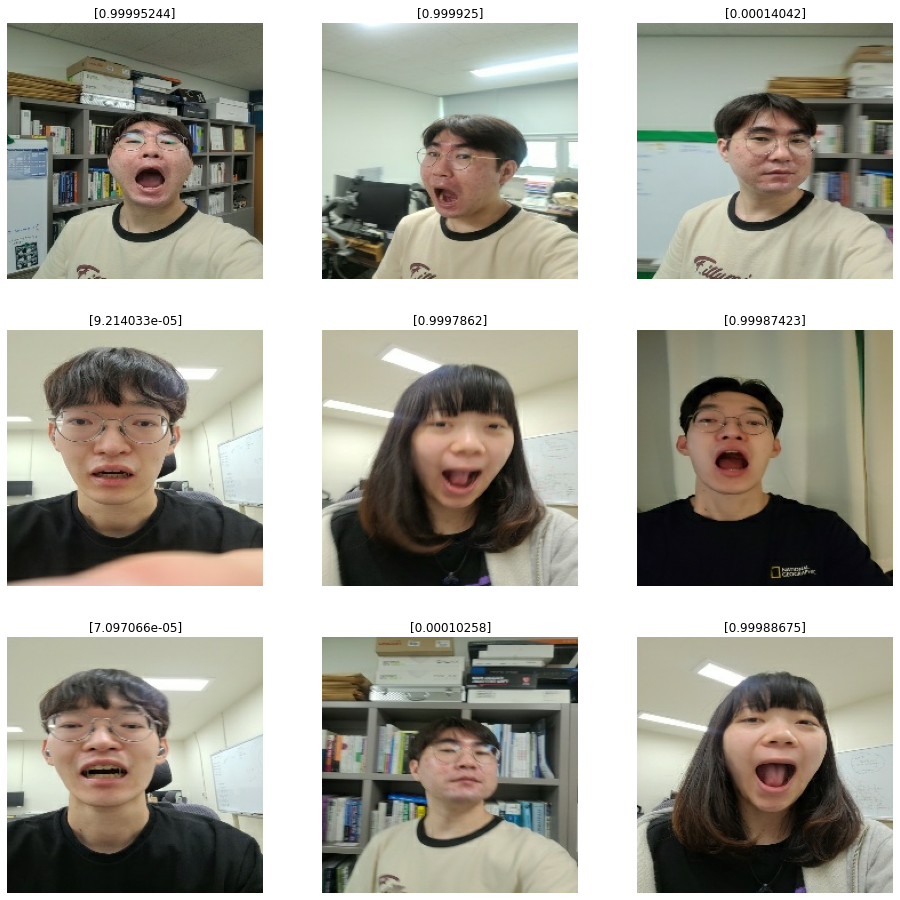

In [ ]:
for i in test_ds.take(1):
    sample = i
sample_input ={}
sample_input['image_landmarks'] = sample[0]['image_landmarks']
sample_input['image'] = sample[0]['image']

cls = model2(sample_input)
plt.figure(figsize=(16, 16))
for i in range(9):
    image = sample_input['image'][i].numpy()
    labels = cls[i].numpy()
    ax = plt.subplot(3, 3, i + 1)
    ax.set_title(labels) 
    plt.imshow(image)
    plt.axis('off')

In [ ]:
lds = list(ds)

(-0.5, 223.5, 223.5, -0.5)

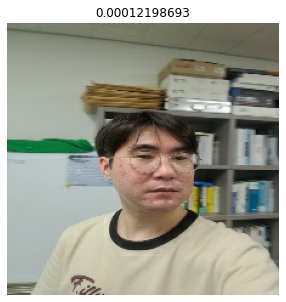

In [ ]:
idx = [13,10]
image_data = lds[idx[0]][0]['image'][idx[1]]
image_landmark_data = lds[idx[0]][0]['image_landmarks'][idx[1]]
cls = model2([np.expand_dims(image_data, 0), np.expand_dims(image_landmark_data, 0)])
fig, ax = plt.subplots(figsize=(5,5))
ax.set_title(str(cls.numpy()[0][0])) 
plt.imshow(image_data)
plt.axis('off')

# moblienetV2 structure

In [ ]:
model1 = keras.models.Sequential()

model1.add(keras.layers.Input(shape=(256,256,3)))
model1.add(tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(256,256,3), alpha=1.0, include_top=False
))
model1.add(keras.layers.Flatten())

model1.add(keras.layers.Dense(128))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.Activation('relu'))
model1.add(keras.layers.Dropout(0.25))

model1.add(keras.layers.Dense(64))

model1.add(keras.layers.Dense(1, activation='sigmoid'))
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 81920)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               10485888  
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [ ]:
history1 = model1.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbackFunction('moblienetV2_noweight'), batch_size=32)

Epoch 1/50
      9/Unknown - 23s 134ms/step - loss: 0.0688 - accuracy: 0.9792
Epoch 1: val_accuracy improved from -inf to 0.69767, saving model to ./Checkpoints/moblienetV2_noweight.h5
9/9 [==============================] - 28s 757ms/step - loss: 0.0688 - accuracy: 0.9792 - val_loss: 7.0072 - val_accuracy: 0.6977
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.69767
9/9 [==============================] - 2s 166ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 3.0622 - val_accuracy: 0.6977
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.69767 to 0.72093, saving model to ./Checkpoints/moblienetV2_noweight.h5
9/9 [==============================] - 4s 474ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3490 - val_accuracy: 0.7209
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 5.4341e-04 - acc

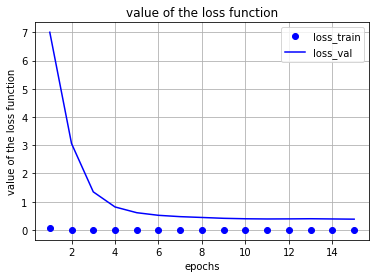

In [ ]:
loss = history1.history['loss']
loss_val = history1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

In [ ]:
train_loss, train_acc = model1.evaluate(train_ds)
print('Train Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model1.evaluate(test_ds)
print('Test Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model1.evaluate(val_ds)
print('Validation Accuracy:', val_acc*100)

9/9 [==============================] - 0s 35ms/step - loss: 0.5436 - accuracy: 0.7917
Train Accuracy: 79.16666865348816


1/1 [==============================] - 0s 264ms/step - loss: 0.6207 - accuracy: 0.7500
Test Accuracy: 75.0


3/3 [==============================] - 1s 62ms/step - loss: 0.3811 - accuracy: 0.8605
Validation Accuracy: 86.04651093482971


## 결과 확인하기

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


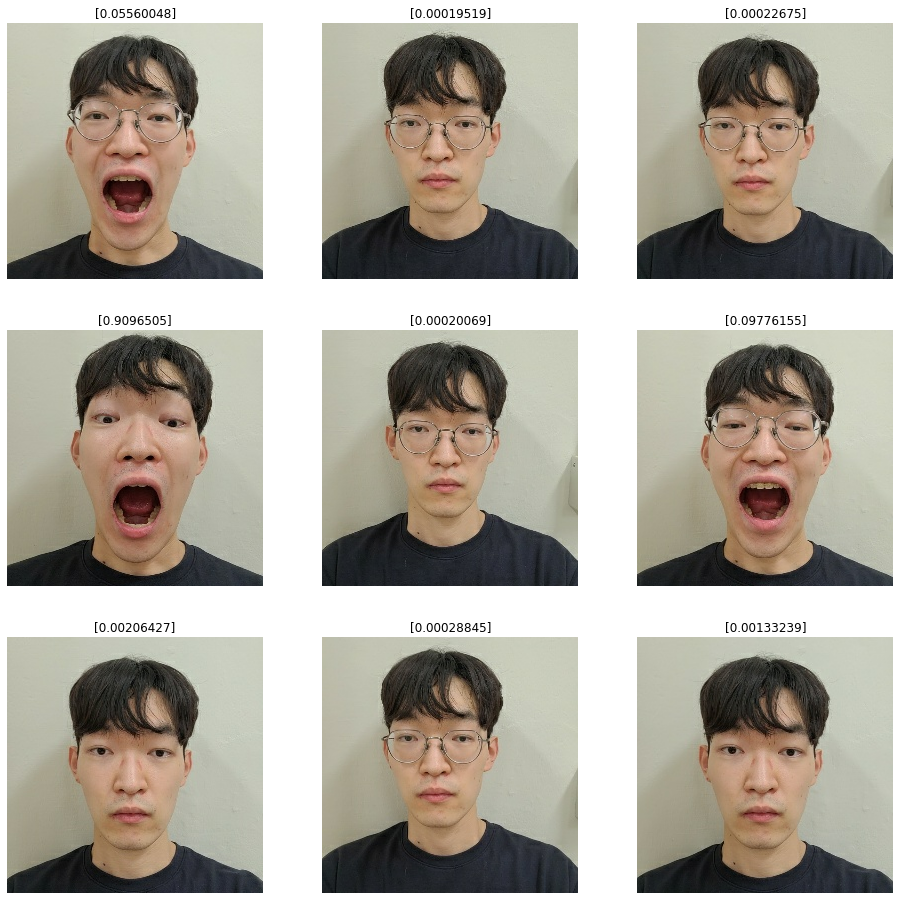

In [ ]:
for i in test_ds.take(1):
    sample = i
sample = sample[0]
cls = model1(sample)
plt.figure(figsize=(16, 16))
for i in range(9):
    image = sample[i].numpy()
    labels = cls[i].numpy()
    ax = plt.subplot(3, 3, i + 1)
    ax.set_title(labels) 
    plt.imshow(image)
    plt.axis('off')